# Chapter 5
Monte Carlo methods - Blackjack examples

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import math

In [61]:
from collections import defaultdict

In [453]:
class Blackjack_env:
    """
    env will be an interface with the following methods:
    start: return a starting state - (dealer first card, sum of player hand, usable ace)
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['h', 's']
    
    def draw_card(self, number_of_cards=1):
        cards = []
        for i in range(number_of_cards):
            card = np.random.randint(2, 15) # 11 is ace, 12, 13, 14 is j, q, k
            if card > 11:
                card = 10
            cards.append(card)
        if number_of_cards == 1:
            return cards[0]
        else:
            return cards
    
    def evaluate_hand(self, cards):
        value = sum(cards)
        if value > 21:
            num_of_ace = sum([card == 11 for card in cards])
            for i in range(num_of_ace):
                value -= 10
                if value <= 21:
                    break
        return value
    
    def has_usable_ace(self, cards):
        if not 11 in cards:
            return False
        value = sum(cards)
        if value > 21:
            num_of_ace = sum([card == 11 for card in cards])
            for i in range(num_of_ace):
                value -= 10
                if value <= 21:
                    ace_left = num_of_ace - i - 1
                    return ace_left > 0
            return False
        else:
            return True
    
    def get_state(self):
        return self.dealer[0], self.evaluate_hand(self.player), self.has_usable_ace(self.player)
    
    def start(self):
        #player = 21
        #dealer = 21
        #while player == 21 or dealer == 21:
        self.dealer = self.draw_card(number_of_cards=2)
        self.player = self.draw_card(number_of_cards=2)
        #    player = self.evaluate_hand(self.player)
        #    dealer = self.evaluate_hand(self.dealer)
        return self.get_state()
    
    def dealer_act(self):
        while(self.evaluate_hand(self.dealer) < 17):
            self.dealer = np.append(self.dealer, values=self.draw_card(number_of_cards=1))

    def act(self, action):

        if len(self.player) == 2 and len(self.dealer) == 2:
            # start
            dealer_hand = self.evaluate_hand(self.dealer)
            player_hand = self.evaluate_hand(self.player)
            if dealer_hand == 21 and player_hand == 21:
                return self.get_state(), 0, True
            elif dealer_hand == 21:
                return self.get_state(), -1, True
            elif player_hand == 21:
                return self.get_state(), 1, True

        if action == 'h':
            self.player = np.append(self.player, values=self.draw_card(number_of_cards=1))
            if self.evaluate_hand(self.player) > 21:
                return self.get_state(), -1, True
            else:
                return self.get_state(), 0, False
        elif action == 's':
            self.dealer_act()
            dealer_hand = self.evaluate_hand(self.dealer)
            player_hand = self.evaluate_hand(self.player)
            if dealer_hand > 21:
                return self.get_state(), 1, True
            elif dealer_hand == player_hand:
                return self.get_state(), 0, True
            elif dealer_hand > player_hand:
                return self.get_state(), -1, True
            else:
                return self.get_state(), 1, True
        else:
            raise("Invalid action")
    
        

## Example 5.1, blackjack monte carlo policy evaluation

In [455]:
class MCAgent:
    def __init__(self, env, policy, discount=1):
        self.env = env
        self.policy = policy
        self.actions = env.actions
        self.V = defaultdict(int)
        self.returns = defaultdict(list)
        self.discount = discount
    
    def evaluate(self, episodes):
        for i in range(episodes):
            G = {}
            step_since_visit = {}
            state = env.start()
            is_end = False
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                if not state in G:
                    G[state] = 0
                    step_since_visit[state] = -1
                for key in G.keys():
                    step_since_visit[key] += 1
                    G[key] += (self.discount ** step_since_visit[key]) * reward
                #if is_end and state[0] == 10 and state[1] == 21 and reward == 0:
                #    print(env.dealer, env.player, state)
                state = next_state
            for state, g in G.items():
                self.returns[state].append(g)
        for state in self.returns.keys():
            self.V[state] = np.mean(self.returns[state])
                

In [607]:
from mpl_toolkits.mplot3d import Axes3D  
from mpl_toolkits.mplot3d import proj3d

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=0.4

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj(ax):
    return lambda : np.dot(Axes3D.get_proj(ax), scale)
    # return np.dot(Axes3D.get_proj(ax), scale)

def plot_value_function(V, no_of_iterations):
    X, Y = np.meshgrid(range(1, 11), range(12, 22)) # X is dealer, Y is player sum
    zs_no = []
    zs_yes = []
    for x,y in zip(np.ravel(X), np.ravel(Y)):
        dealer = 11 if x == 1 else x
        zs_no.append(V[(dealer, y, False)])
        zs_yes.append(V[(dealer, y, True)])
    Z_no = np.array(zs_no).reshape(X.shape)
    Z_yes = np.array(zs_yes).reshape(X.shape)
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_yes)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Value')
    ax.set_zticks([-1, 1])
    ax.set_title('Usable ace, %d episodes' %no_of_iterations)
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    
    ax = fig.add_subplot(122, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_no)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Value')
    ax.set_zticks([-1, 1])
    ax.set_title('Unusable ace, %d episodes' %no_of_iterations)
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.show()

In [454]:
env = Blackjack_env()

In [603]:
bj_agent = MCAgent(env, lambda state: 'h' if state[1] < 20 else 's')

In [604]:
bj_agent.evaluate(10000)

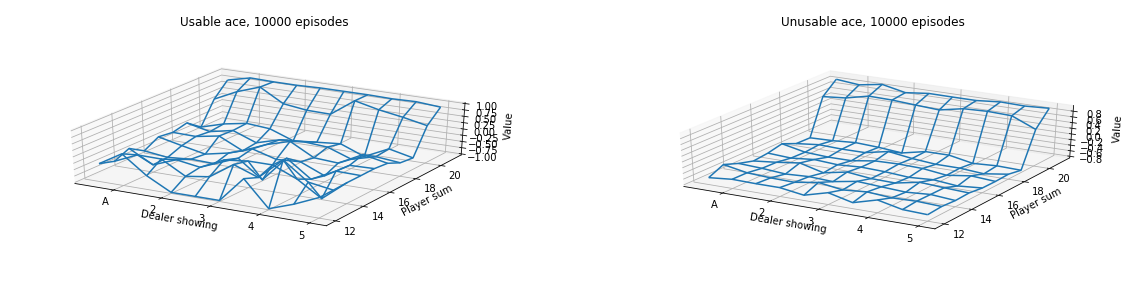

In [605]:
plot_value_function(bj_agent.V, 10000)

In [606]:
bj_agent.evaluate(500000-10000) # to complete 500,000 episodes

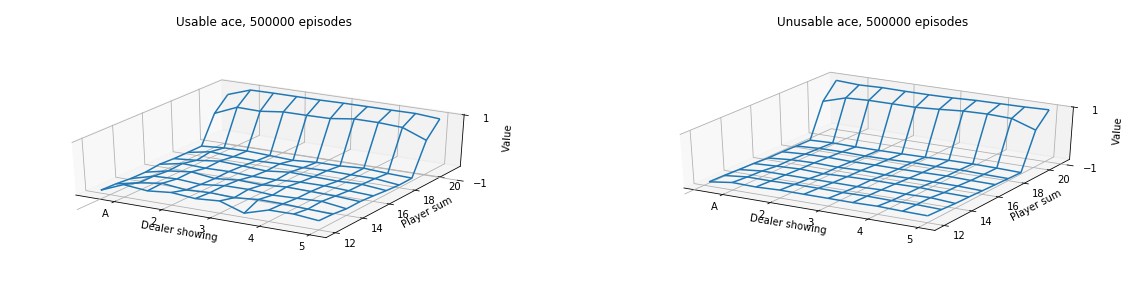

In [608]:
plot_value_function(bj_agent.V, 500000)

## Example 5.3, Monte carlo control with exploring start

In [515]:
class MCESAgent:
    def __init__(self, env, policy=None, discount=1):
        self.env = env
        self.actions = env.actions
        if policy:
            self.policy = policy
        else:
            self.policy = defaultdict(lambda : self.actions[0])
        self.Q = defaultdict(int)
        self.returns = defaultdict(list)
        self.discount = discount
    
    def train(self, episodes):
        for i in range(episodes):
            G = {}
            step_since_visit = {}
            state = env.start()
            action = np.random.choice(self.actions)
            is_end = False
            while not is_end:
                next_state, reward, is_end = self.env.act(action)
                if not (state, action) in G:
                    G[state, action] = 0
                    step_since_visit[state, action] = -1
                for key in G.keys():
                    step_since_visit[key] += 1
                    G[key] += (self.discount ** step_since_visit[key]) * reward
                state = next_state
                action = self.policy[state]
            for key, g in G.items():
                self.returns[key].append(g)
                self.Q[key] = np.mean(self.returns[key])
            for state, _ in G.keys():
                best_value = -1000
                best_action = None
                for action in self.actions:
                    value = self.Q[state, action]
                    if value > best_value:
                        best_value = value
                        best_action = action
                self.policy[state] = best_action
                    

In [516]:
bj_mces_agent = MCESAgent(env, policy=defaultdict(lambda state: 'h' if state[1] < 20 else 's'))

In [517]:
bj_mces_agent.train(5000000)

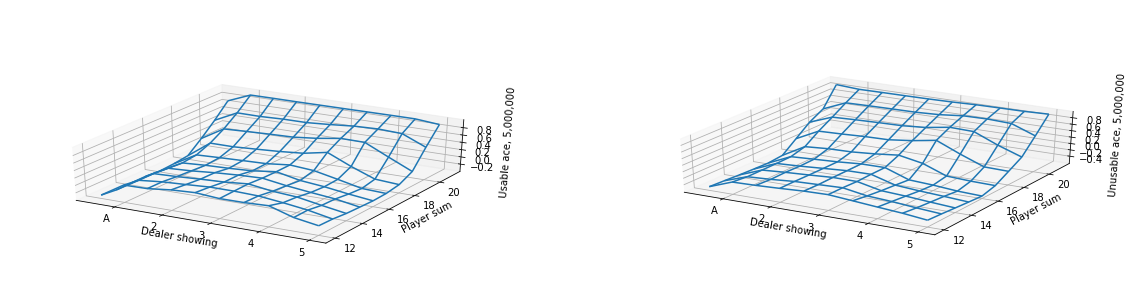

In [589]:
def plot_value_from_q(Q, policy):
    X, Y = np.meshgrid(range(1, 11), range(12, 22)) # X is dealer, Y is player sum
    zs_no = []
    zs_yes = []
    for x,y in zip(np.ravel(X), np.ravel(Y)):
        dealer = 11 if x == 1 else x
        zs_no.append(Q[(dealer, y, False), policy[(dealer, y, False)]])
        zs_yes.append(Q[(dealer, y, True), policy[(dealer, y, True)]])
    Z_no = np.array(zs_no).reshape(X.shape)
    Z_yes = np.array(zs_yes).reshape(X.shape)

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_yes)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Usable ace, 5,000,000')
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])

    ax = fig.add_subplot(122, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_no)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Unusable ace, 5,000,000')
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.show()
    
plot_value_from_q(bj_mces_agent.Q, bj_mces_agent.policy)

In [564]:
def plot_policy(policy):
    X, Y = np.meshgrid(np.linspace(1, 10, 100), np.linspace(11, 21, 100)) # X is dealer, Y is player sum
    zs_no = []
    zs_yes = []
    for x,y in zip(np.ravel(X), np.ravel(Y)):
        x = int(math.floor(x))
        y = int(math.floor(y))
        dealer = 11 if x == 1 else x
        zs_no.append(0 if bj_mces_agent.policy[(dealer, y, False)] == 'h' else 1)
        zs_yes.append(0 if bj_mces_agent.policy[(dealer, y, True)] == 'h' else 1)
    Z_no = np.array(zs_no).reshape(X.shape)
    Z_yes = np.array(zs_yes).reshape(X.shape)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    plot = ax.contourf(X, Y, Z_yes)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    plt.title('Usable ace, 5,000,000')
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.text(5, 19.5, 'Stick', fontsize=15)
    ax.text(5, 14, 'Hit', color='white', fontsize=15)

    ax = fig.add_subplot(122)
    ax.contourf(X, Y, Z_no)

    ax.set_xlabel('Dealer showing')
    ax.set_ylim(11, 21)
    ax.set_ylabel('Player sum')
    plt.title('Unusable ace, 5,000,000')
    ax.text(5, 19.5, 'Stick', fontsize=15)
    ax.text(8, 14, 'Hit', color='white', fontsize=15)
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.show()

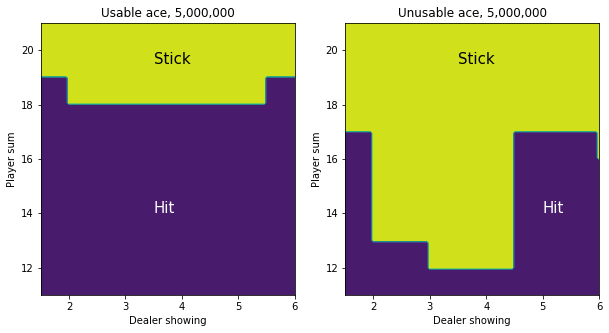

In [565]:
plot_policy(bj_mces_agent.policy)

## Example 5.4

### Computing the value of state (11, 13, True) of target policy

In [625]:
# we will use an incremental approach to computing the average return
state_value = 0
for i in range(100000):
    # initiate the starting state to (11, 13, True)
    env.dealer = [2, env.draw_card(number_of_cards=1)]
    env.player = [11, 2] # this is equivalent to 11, 11, 11
    is_end = False
    action = 'h'
    while not is_end:
        (_, player_sum, _), reward, is_end = env.act(action)
        if player_sum < 20:
            action = 'h'
        else:
            action = 's'
    # ended, update value
    state_value += 1/(i+1) * (reward - state_value)
print(state_value)

-0.27489999999999737


### Computing the value of state (11, 13, True) using OIS

In [646]:
def compute_estimate_error_ois(target_value, episodes):
    state_value = [0]
    for i in range(episodes):
        # initiate the starting state to (11, 13, True)
        env.dealer = [2, env.draw_card(number_of_cards=1)]
        env.player = [11, 2] # this is equivalent to 11, 11, 11
        player_sum = 13
        is_end = False
        p = 1
        while not is_end:
            action = np.random.choice(['h', 's'])
            target_action = 'h' if player_sum < 20 else 's'
            (_, player_sum, _), reward, is_end = env.act(action)
            if action == target_action:
                p *= 1/0.5 # pi(a|s) = 1, mu(a|s) = 0.5
            else:
                p = 0
                break
        state_value.append(state_value[-1] + 1/(i+1) * ((p * reward) - state_value[-1]))
    return np.square(np.array(state_value) - target_value)

In [649]:
errors_ois = list(map(np.mean, zip(*[compute_estimate_error_ois(state_value, 10000) for i in range(100)])))

### Computing the value of state (11, 13, True) using WIS

In [662]:
def compute_estimate_error_wis(target_value, episodes):
    state_value = [0]
    c = 0
    for i in range(episodes):
        # initiate the starting state to (11, 13, True)
        env.dealer = [2, env.draw_card(number_of_cards=1)]
        env.player = [11, 2] # this is equivalent to 11, 11, 11
        player_sum = 13
        is_end = False
        p = 1
        while not is_end:
            action = np.random.choice(['h', 's'])
            target_action = 'h' if player_sum < 20 else 's'
            (_, player_sum, _), reward, is_end = env.act(action)
            if action == target_action:
                p *= 1/0.5 # pi(a|s) = 1, mu(a|s) = 0.5
            else:
                p = 0
                break
        if p == 0:
            state_value.append(state_value[-1])
        else:
            c += p
            state_value.append(state_value[-1] + p/c * (reward - state_value[-1]))
    return np.square(np.array(state_value) - target_value)

In [665]:
errors_wis = list(map(np.mean, zip(*[compute_estimate_error_wis(state_value, 10000) for i in range(100)])))

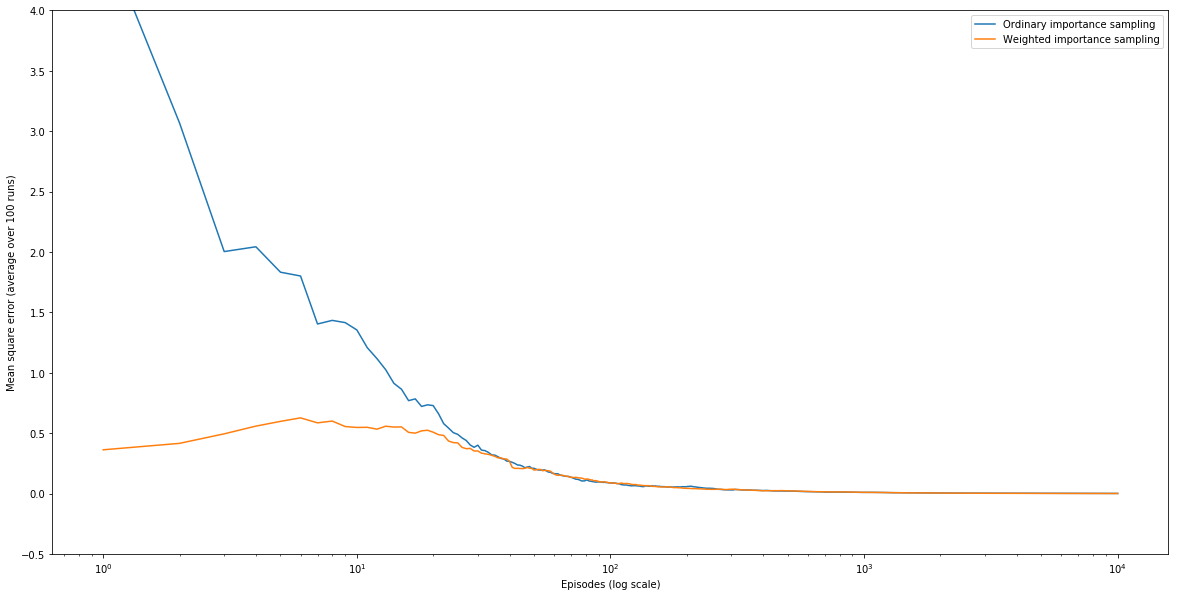

In [669]:
plt.figure(figsize=(20,10))
plt.plot(range(10000), errors_ois[1:], label="Ordinary importance sampling")
plt.plot(range(10000), errors_wis[1:], label="Weighted importance sampling")
plt.ylabel('Mean square error (average over 100 runs)')
plt.xlabel('Episodes (log scale)')
plt.xscale('log')
plt.ylim([-0.5, 4])
plt.legend()

## Example 5.5 Infinite variance

In [684]:
runs = []
for run in range(10):
    estimates = [0]
    for i in range(100000): # i dont have the computation power to run 100 million episodes
        is_end = False
        p = 1
        reward = 0
        while not is_end:
            action = np.random.choice(['back', 'end'])
            if action == 'back': # target policy is back only
                p *= 1/0.5 # pi = 1, mu = 0.5
                is_end = np.random.uniform() < 0.1
                if is_end:
                    reward = 1
            else:
                p = 0
                break
        estimates.append(estimates[-1] + 1/(i+1) * (p * reward - estimates[-1]))
    runs.append(estimates)
    
# I believe what I coded here is first visit monte carlo

(0, 4)

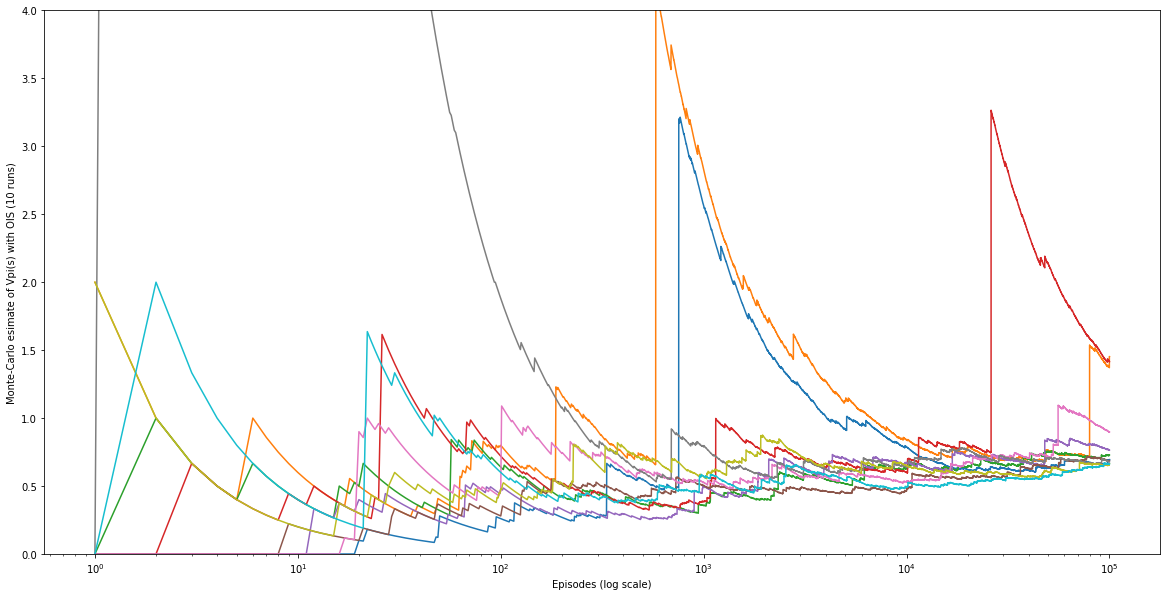

In [699]:
plt.figure(figsize=(20,10))
for run in runs:
    plt.plot(range(100001), run)
plt.xscale('log')
plt.ylabel('Monte-Carlo esimate of Vpi(s) with OIS (10 runs)')
plt.xlabel('Episodes (log scale)')
plt.ylim([0, 4])

The book suggests that with WIS, the value will converge to 1 after the first episode that ends with the 'back' action.

Here's my attempt at replicating that result

In [708]:
wis_runs = []
for run in range(10):
    estimates = [0]
    c = 0
    for i in range(1000): 
        is_end = False
        p = 1
        reward = 0
        while not is_end:
            action = np.random.choice(['back', 'end'])
            if action == 'back': # target policy is back only
                p *= 1/0.5 # pi = 1, mu = 0.5
                is_end = np.random.uniform() < 0.1
                if is_end:
                    reward = 1
            else:
                p = 0
                break
        if p == 0:
            estimates.append(estimates[-1])
        else:
            c += p
            estimates.append(estimates[-1] + p/c * (reward - estimates[-1]))
    wis_runs.append(estimates)

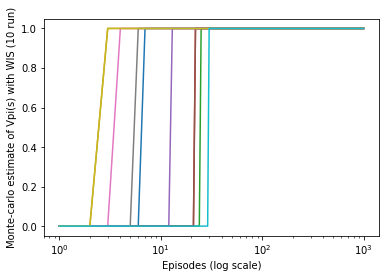

In [709]:
for run in wis_runs:
    plt.plot(range(1001), run)
plt.ylabel('Monte-carlo estimate of Vpi(s) with WIS (10 run)')
plt.xlabel('Episodes (log scale)')
plt.xscale('log')

Indeed, the value converge to 1 once it first reach 'back' as a terminating action. Since it is stochastic and happens only 10% of the time, we see that most runs only converge to that value when no. of episodes approaches/surpass 10

## Exercise 5.8

In [1168]:
class track_env:
    def __init__(self):
        track = np.zeros((50,50))
        i = 0
        left = 15
        while i < 45:
            if i > 40:
                left += 1
            elif i > 0 and np.random.uniform() < 0.3:
                left -= 1
            left = max(left, 5)
            if i <38:
                right = 20
            elif i < 39:
                right = 21
            else:
                right = 50

            row = i
            track[left:right, row] = 2 if i == 0 else 1
            i+=1

        track[-1, :]  *= 2
        self.start_line = [(i, 0) for i in range(15, 20)]
        self.end_line = [(49, i) for i in range(39, 45)]
        self.track = track
        self.noise = False
        self.default_action = (0,0)
        
        
    # state is a tuple of coor, velocity
    def allowed_actions(self, state=None):
        if state:
            velocity = state[1]
        else:
            velocy = self.velocity
        return [(i, j) 
                    for i in range(-1 if velocity[0] > 0 else 0, 2 if velocity[0] < 4 else 1)
                    for j in range(-1 if velocity[1] > 0 else 0, 2 if velocity[1] < 4 else 1)]

    def print_track(self, trajectories=None):
        X, Y = np.meshgrid(np.linspace(0, 49, 200), np.linspace(0, 49, 200)) # X is dealer, Y is player sum
        z = []
        for x,y in zip(np.ravel(X), np.ravel(Y)):
            x = int(math.ceil(x))
            y = int(math.floor(y))
            z.append(self.track[x, y])
        Z = np.array(z).reshape(X.shape)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.set_xlim((0,49))
        ax.set_ylim((0,49))
        plot = ax.contourf(X, Y, Z)
        if trajectories:
            for trajectory in trajectories:
                ax.plot(*zip(*trajectory))
        
    def start(self):
        self.coor = self.start_line[np.random.randint(0, len(self.start_line))]
        self.velocity = (0,0)
        self.state = self.coor, self.velocity # state is coor, velocity. velocity is tuple of x y velocity
        return self.state

    def act(self, action):
        if not self.noise or np.random.uniform() > 0.1:
            # only modify velocity if it isn't noisy or 90% of the time when noisy
            self.velocity = self.velocity[0] + action[0], self.velocity[1] + action[1]
        next_coor = self.coor[0] + self.velocity[0], self.coor[1] + self.velocity[1]
        is_end = False
        reward = -1
        # check if crosses finishing line
        for i in range(self.velocity[0] + 1):
            for j in range(self.velocity[1] + 1):
                x = self.coor[0] + i
                y = self.coor[1] + i
                if x < 50 and y < 50 and y > 0:
                    if self.track[x, y] == 2:
                        is_end = True
                        reward = 1
                        next_coor = (x,y)
        # check if it touches boundary
        if next_coor[0] > 49 or next_coor[0] < 0 or next_coor[1] > 49 or next_coor[1] < 0 or self.track[next_coor] == 0:
            # touched / cross boundaries
            # go back to start line
            next_coor = self.start_line[np.random.randint(0, len(self.start_line))]
            self.velocity = (0,0)
        self.coor = next_coor
        self.state = next_coor, self.velocity
        return self.state, reward, is_end
        

In [1169]:
track = track_env()

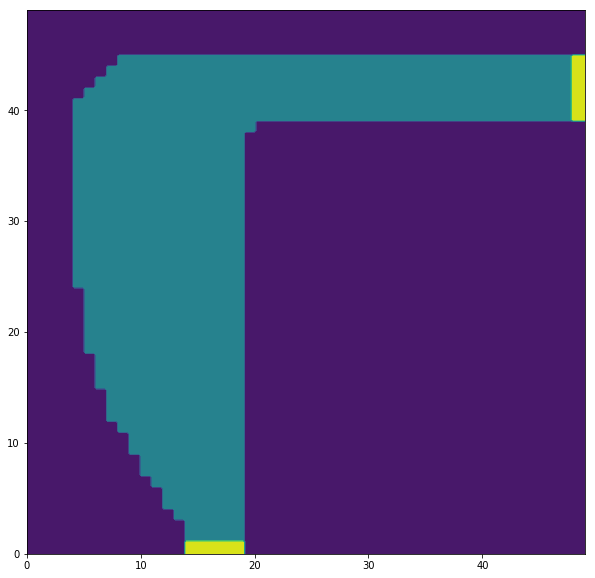

In [1170]:
track.print_track()

In [1215]:
class OMCCAgent:
    # Off policy Monte carlo control agent
    # every visit
    """
    Params: 
        environment with start and act method as well as an allowed_actions method and default_action field
    """
    def __init__(self, env, discount=1, e=1):
        self.env = env
        self.Q = defaultdict(lambda : 0) # pessismistic initialization
        self.C = defaultdict(int)
        self.policy = defaultdict(lambda : env.default_action)
        self.discount = discount
        self.e = e
        
    def behavior_policy(self, state):
        action = None
        allowed_actions = self.env.allowed_actions(state)
        if np.random.uniform() < self.e:
            action = allowed_actions[np.random.randint(len(allowed_actions))]
        else:
            action = self.policy[state]
        if action == self.policy[state]:
            prob = (1 - self.e) + self.e/len(allowed_actions)
        else:
            prob = self.e / len(allowed_actions)
        return action, prob
    
    def train(self, episodes):
        for i in range(episodes):
            if i % 100 == 0:
                print('episode %d' %i)
            episode = self.generate_episode()
            
            G = 0
            W = 1
            for t in range(len(episode) -2, -1, -1):
                # go from T-1 down to 0
                state, action, prob, reward = episode[t]
                G = self.discount * G + reward
                self.C[(state, action)] += W
                self.Q[(state, action)] += W/self.C[(state, action)] * (G - self.Q[(state, action)])
                allowed_actions = self.env.allowed_actions(state)
                self.policy[state] = allowed_actions[np.argmax(map(lambda x: self.Q[state, x], allowed_actions))]
                # map the action to compute Q for them. argmax over them and use the index to select the best action
                if not action == self.policy[state]:
                    break
                W *= 1/prob # W *= 1/mu(A|S)
                
        
    def generate_episode(self, use_behavior_policy = True):
        episode = []
        state = self.env.start()
        action, prob = self.behavior_policy(state) if use_behavior_policy else (self.policy[state], 1)
        is_end = False
        while not is_end:
            next_state, reward, is_end = self.env.act(action) 
            episode.append((state, action, prob, reward)) # i am storing St, At, prob and Rt+1 as a tuple into the episode
            state = next_state
            action, prob = self.behavior_policy(state) if use_behavior_policy else (self.policy[state], 1)
        episode.append((state, None, None)) # store ST with no action and reward
        return episode
            

In [1218]:
racecar_agent = OMCCAgent(track, e=0.1)
for start in track.start_line:
    racecar_agent.policy[start, (0,0)] = (0,1) # init starting line policy

In [1219]:
episode = racecar_agent.generate_episode()

In [1220]:
trajectories = [list(map(lambda x: x[0][0], episode))]

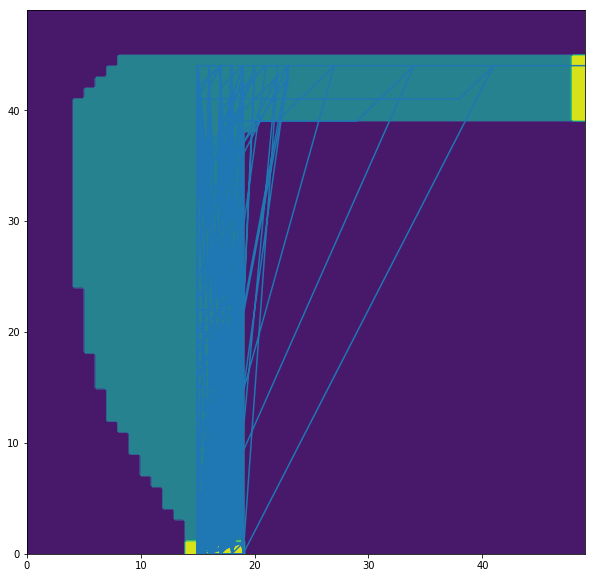

In [1221]:
track.print_track(trajectories=trajectories)

In [1222]:
track.noise=True
racecar_agent.train(100000)

episode 0
episode 100
episode 200
episode 300
episode 400
episode 500
episode 600
episode 700
episode 800
episode 900
episode 1000
episode 1100
episode 1200
episode 1300
episode 1400
episode 1500
episode 1600
episode 1700
episode 1800
episode 1900
episode 2000
episode 2100
episode 2200
episode 2300
episode 2400
episode 2500
episode 2600
episode 2700
episode 2800
episode 2900
episode 3000
episode 3100
episode 3200
episode 3300
episode 3400
episode 3500
episode 3600
episode 3700
episode 3800
episode 3900
episode 4000
episode 4100
episode 4200
episode 4300
episode 4400
episode 4500
episode 4600
episode 4700
episode 4800
episode 4900
episode 5000
episode 5100
episode 5200
episode 5300
episode 5400
episode 5500
episode 5600
episode 5700
episode 5800
episode 5900
episode 6000
episode 6100
episode 6200
episode 6300
episode 6400
episode 6500
episode 6600
episode 6700
episode 6800
episode 6900
episode 7000
episode 7100
episode 7200
episode 7300
episode 7400
episode 7500
episode 7600
episode 770

episode 59400
episode 59500
episode 59600
episode 59700
episode 59800
episode 59900
episode 60000
episode 60100
episode 60200
episode 60300
episode 60400
episode 60500
episode 60600
episode 60700
episode 60800
episode 60900
episode 61000
episode 61100
episode 61200
episode 61300
episode 61400
episode 61500
episode 61600
episode 61700
episode 61800
episode 61900
episode 62000
episode 62100
episode 62200
episode 62300
episode 62400
episode 62500
episode 62600
episode 62700
episode 62800
episode 62900
episode 63000
episode 63100
episode 63200
episode 63300
episode 63400
episode 63500
episode 63600
episode 63700
episode 63800
episode 63900
episode 64000
episode 64100
episode 64200
episode 64300
episode 64400
episode 64500
episode 64600
episode 64700
episode 64800
episode 64900
episode 65000
episode 65100
episode 65200
episode 65300
episode 65400
episode 65500
episode 65600
episode 65700
episode 65800
episode 65900
episode 66000
episode 66100
episode 66200
episode 66300
episode 66400
episod

KeyboardInterrupt: 

In [1225]:
track.noise=False
episode = racecar_agent.generate_episode(use_behavior_policy=True)
track.noise=True

KeyboardInterrupt: 

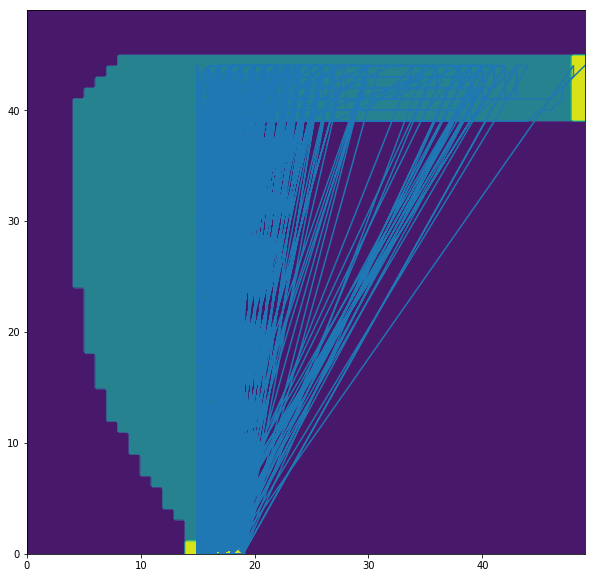

In [1224]:
trajectories = [list(map(lambda x: x[0][0], episode))]
track.print_track(trajectories=trajectories)

In [1104]:
racecar_agent.policy[(40,42), (1,0)]

(0, 0)

In [1226]:
for key, policy in racecar_agent.policy.items():
    if not policy == (0,0):
        print(key, policy)

((15, 0), (0, 0)) (0, 1)
((16, 0), (0, 0)) (0, 1)
((17, 0), (0, 0)) (0, 1)
((18, 0), (0, 0)) (0, 1)
((19, 0), (0, 0)) (0, 1)
((35, 44), (2, 0)) (-1, 0)
((37, 44), (2, 0)) (-1, 0)
((39, 44), (2, 0)) (-1, 0)
((41, 44), (2, 0)) (-1, 0)
((43, 44), (2, 0)) (-1, 0)
((45, 44), (2, 0)) (-1, 0)
((47, 44), (2, 0)) (-1, 0)
((49, 44), (2, 0)) (-1, 0)
((37, 42), (2, 1)) (-1, -1)
((39, 43), (2, 1)) (-1, -1)
((41, 44), (2, 1)) (-1, -1)
((32, 42), (2, 0)) (-1, 0)
((34, 42), (2, 0)) (-1, 0)
((36, 42), (2, 0)) (-1, 0)
((38, 42), (2, 0)) (-1, 0)
((40, 42), (2, 0)) (-1, 0)
((42, 42), (2, 0)) (-1, 0)
((44, 42), (2, 0)) (-1, 0)
((46, 42), (2, 0)) (-1, 0)
((48, 42), (2, 0)) (-1, 0)
((49, 43), (2, 0)) (-1, 0)
((34, 43), (2, 0)) (-1, 0)
((36, 43), (2, 0)) (-1, 0)
((38, 43), (2, 0)) (-1, 0)
((40, 43), (2, 0)) (-1, 0)
((42, 43), (2, 0)) (-1, 0)
((44, 43), (2, 0)) (-1, 0)
((46, 43), (2, 0)) (-1, 0)
((48, 43), (2, 0)) (-1, 0)
((30, 40), (3, 0)) (-1, 0)
((33, 40), (3, 0)) (-1, 0)
((36, 40), (3, 0)) (-1, 0)
((39, 40

In [1205]:
allowed_actions = track.allowed_actions(((17, 40), (0, 0)))
# allowed_actions[np.argmax(map(lambda x: self.Q[state, x], allowed_actions))]

In [1206]:
allowed_actions

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [1207]:
list(map(lambda x: racecar_agent.Q[((17, 40), (0, 0)), x], allowed_actions))

[-1000, -1000, -1000, -1000]

In [1199]:
racecar_agent.Q[((47,42), (3,1)), (1,0)]

-1000

In [1195]:
racecar_agent.Q.items()

dict_items([((((48, 42), (2, 1)), (0, 0)), 1.0), ((((49, 44), (1, 0)), (0, 0)), 1.0), ((((49, 44), (2, 0)), (0, 0)), 1.0), ((((47, 40), (2, 1)), (0, 0)), 1.0), ((((47, 39), (2, 0)), (0, 0)), 1.0), ((((48, 42), (2, 0)), (0, 0)), 1.0), ((((48, 40), (1, 0)), (0, 0)), 1.0), ((((48, 41), (2, 0)), (0, 0)), 1.0), ((((46, 39), (2, 0)), (1, 0)), 0.7692307692307693), ((((48, 40), (2, 0)), (0, 0)), 1.0), ((((48, 43), (2, 0)), (0, 0)), 1.0), ((((47, 42), (4, 0)), (0, 0)), 1.0), ((((47, 42), (2, 0)), (0, 0)), 1.0), ((((48, 39), (1, 0)), (1, 1)), 1.0), ((((47, 39), (2, 0)), (-1, 0)), 0.8064516129032259), ((((45, 39), (2, 0)), (0, 0)), 0.0), ((((47, 41), (2, 0)), (0, 0)), 1.0), ((((49, 44), (3, 0)), (0, 0)), 1.0), ((((47, 40), (3, 1)), (0, 1)), 1.0), ((((49, 44), (2, 1)), (0, 0)), 1.0), ((((48, 43), (3, 0)), (0, 0)), 1.0), ((((49, 44), (1, 0)), (-1, 0)), 1.0), ((((48, 44), (1, 0)), (0, 0)), 0.0), ((((48, 39), (0, 0)), (1, 1)), 1.0), ((((48, 40), (2, 0)), (0, 1)), 1.0), ((((48, 40), (2, 0)), (-1, 1)),

In [1188]:
racecar_agent.Q['lar']

-1000